<a href="https://colab.research.google.com/github/khanhvietdm-glitch/BTC-Trading/blob/main/TRAIN_AND_TEST_FSRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#Train and test
#!/usr/bin/env python3
# fsrl_full_with_strategy_column_fixed.py
#
# pip install pandas numpy scikit-learn stable-baselines3 gym matplotlib openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import gym
from gym import spaces
from stable_baselines3 import DQN

# =========================
# 1. Đọc & tiền xử lý dữ liệu
# =========================
xls = pd.ExcelFile('/content/crypto_daily_data.xlsx')
btc = pd.read_excel(xls, 'BTC_Daily')
btc['time'] = pd.to_datetime(btc['time'])
btc = btc.set_index('time').sort_index()

def add_technical(df):
    df = df.copy()
    df['log_ret'] = np.log(df['close']).diff()
    delta = df['close'].diff()
    gain  = delta.clip(lower=0).rolling(14).mean()
    loss  = (-delta.clip(upper=0)).rolling(14).mean().replace(0,1e-6)
    df['rsi']     = 100 - 100/(1 + gain/loss)
    df['sma_5']   = df['close'].rolling(5).mean()
    df['sma_10']  = df['close'].rolling(10).mean()
    mb            = df['close'].rolling(20).mean()
    sigma         = df['close'].rolling(20).std()
    df['boll_up'] = mb + 2*sigma
    df['boll_lb'] = mb - 2*sigma
    return df.dropna()

btc = add_technical(btc)

# Tách train/test
split_date = '2022-01-01'
train_df = btc[:split_date]
test_df  = btc[split_date:]

# =========================
# 2. Scale & PCA
# =========================
features   = ['log_ret','rsi','sma_5','sma_10','boll_up','boll_lb','volume']
scaler     = MinMaxScaler()
pca        = PCA(n_components=5)
train_vals = scaler.fit_transform(train_df[features])
test_vals  = scaler.transform(test_df[features])
train_pca  = pca.fit_transform(train_vals)
test_pca   = pca.transform(test_vals)

# =========================
# 3. Định nghĩa môi trường FSRL (fixed action handling)
# =========================
class FSRLEnv(gym.Env):
    def __init__(self, df, pca_arr, window=20, cash_start=1e6):
        super().__init__()
        self.df           = df.reset_index(drop=True)
        self.times_index  = df.index
        self.pca_arr      = pca_arr
        self.window       = window
        self.cash_start   = cash_start
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window * pca_arr.shape[1],),
            dtype=np.float32
        )
        self.reset()

    def reset(self):
        self.t       = self.window
        self.cash    = self.cash_start
        self.nav     = [self.cash]
        self.times   = []
        self.signals = []
        self.actions = []
        return self._get_state()

    def _get_state(self):
        return self.pca_arr[self.t-self.window:self.t].flatten()

    def step(self, action):
        # ALWAYS convert to Python int (handles np.int64, np.ndarray of size 1, etc.)
        action = int(action)

        row = self.df.iloc[self.t]
        # Ánh xạ action → tín hiệu
        if action == 0:
            signal = 1 if row.rsi < 30 else (-1 if row.rsi > 70 else 0)
        elif action == 1:
            signal = 1 if row.sma_5 > row.sma_10 else (-1 if row.sma_5 < row.sma_10 else 0)
        elif action == 2:
            signal = 1 if row.close < row.boll_lb else (-1 if row.close > row.boll_up else 0)
        elif action == 3:
            mom    = (row.close / self.df.close.iloc[self.t-20]) - 1
            signal = 1 if mom > 0 else -1
        else:
            prices = self.df.close.iloc[self.t-20:self.t]
            vols   = self.df.volume.iloc[self.t-20:self.t]
            vwap   = (prices * vols).sum() / vols.sum()
            signal = 1 if row.close < vwap else -1

        # Cập nhật NAV
        ret = signal * row.log_ret
        self.cash *= np.exp(ret)
        self.nav.append(self.cash)

        # Lưu lịch sử
        self.signals.append(signal)
        self.actions.append(action)
        self.times.append(self.times_index[self.t])

        self.t += 1
        done = self.t >= len(self.df)
        return self._get_state(), ret, done, {}

# =========================
# 4. Huấn luyện & lưu model
# =========================
env_train = FSRLEnv(train_df, train_pca)
model     = DQN(
    "MlpPolicy", env_train,
    learning_rate=5e-5, gamma=0.1,
    buffer_size=50_000,
    exploration_fraction=0.3,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.06,
    verbose=1
)
model.learn(total_timesteps=200_000)
model.save("fsrl_crypto_model")

# =========================
# 5. Load & test model
# =========================
env_test = FSRLEnv(test_df, test_pca)
model    = DQN.load("fsrl_crypto_model", env=env_test)
obs      = env_test.reset()
done     = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env_test.step(action)

# =========================
# 6. Xuất trades ra Excel với cột chiến lược
# =========================
strategy_map = {
    0: 'RSI-Strategy',
    1: 'SMA-Crossover',
    2: 'Bollinger-Reversion',
    3: 'Momentum-20d',
    4: 'VWAP-Reversion'
}

trades = pd.DataFrame({
    'time':   env_test.times,
    'action': env_test.actions,
    'signal': env_test.signals,
    'nav':    [env_test.nav[i+1] for i in range(len(env_test.signals))]
})
trades['strategy'] = trades['action'].map(strategy_map)
trades = trades[trades['signal'] != 0]
trades.to_excel('trade_signals_with_strategy.xlsx', index=False)

# =========================
# 7. Vẽ NAV Curve + Buy/Sell markers
# =========================
nav_times  = [test_df.index[env_test.window]] + env_test.times
nav_vals   = env_test.nav
buy_times  = trades['time'][trades['signal'] == 1].tolist()
buy_vals   = trades['nav'][trades['signal'] == 1].tolist()
sell_times = trades['time'][trades['signal'] == -1].tolist()
sell_vals  = trades['nav'][trades['signal'] == -1].tolist()

plt.figure(figsize=(12,6))
plt.plot(nav_times, nav_vals, label='NAV', linewidth=2)
plt.scatter(buy_times, buy_vals, marker='^', color='green',  s=80, label='Buy')
plt.scatter(sell_times, sell_vals, marker='v', color='red',    s=80, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install stable_baselines3
!pip install ta
!pip install 'shimmy>=2.0'

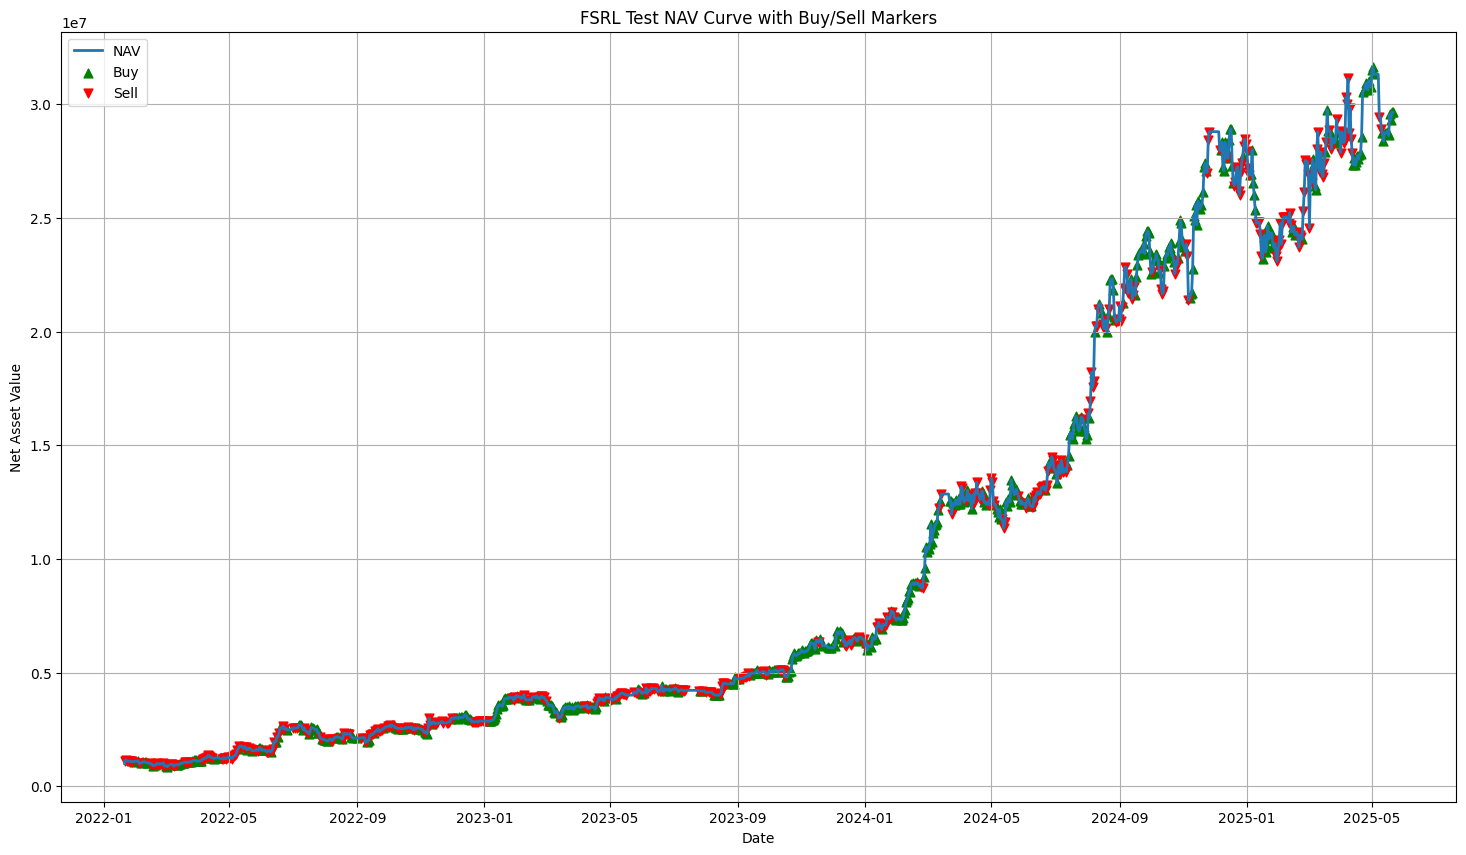

In [ ]:
plt.figure(figsize=(18,10))
plt.plot(nav_times, nav_vals, label='NAV', linewidth=2)
plt.scatter(buy_times, buy_vals, marker='^', color='green',  s=40, label='Buy')
plt.scatter(sell_times, sell_vals, marker='v', color='red',    s=40, label='Sell')
plt.title('FSRL Test NAV Curve with Buy/Sell Markers')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend()
plt.grid(True)
plt.show()